# Q1 

Image in the repo directory

# Q2 

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
“package ‘pander’ was built under R version 4.0.3”

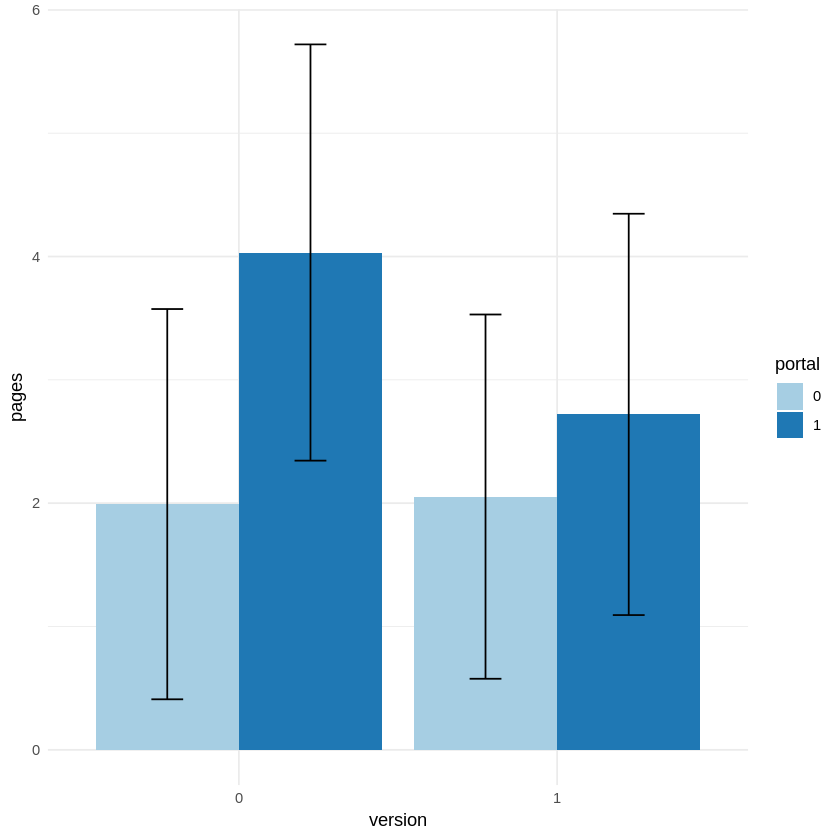

In [13]:
#importing relevant libs

library(foreign)
library(ggplot2)
library(plyr)
library(pander)

data <- read.csv('./webvisit0.csv', header=TRUE)

# changing dtype of the factors
data$portal = as.factor(data$portal)
data$version = as.factor(data$version)

# Function to calculate the mean and the standard deviation for each factor group

data_summary <- function(data, varname, groupnames){
  require(plyr)
  summary_func <- function(x, col){
    c(mean = mean(x[[col]], na.rm=TRUE),
      sd = sd(x[[col]], na.rm=TRUE))
  }
  data_sum<-ddply(data, groupnames, .fun=summary_func,
                  varname)
  data_sum <- rename(data_sum, c("mean" = varname))
 return(data_sum)
}

df3 <- data_summary(data, varname="pages", 
                    groupnames=c("version", "portal"))

p <- ggplot(df3, aes(x=version, y=pages, fill=portal)) + 
   geom_bar(stat="identity", position=position_dodge()) +
  geom_errorbar(aes(ymin=pages-sd, ymax=pages+sd), width=.2,
                 position=position_dodge(.9))
  
p + scale_fill_brewer(palette="Paired") + theme_minimal()

# Q3 

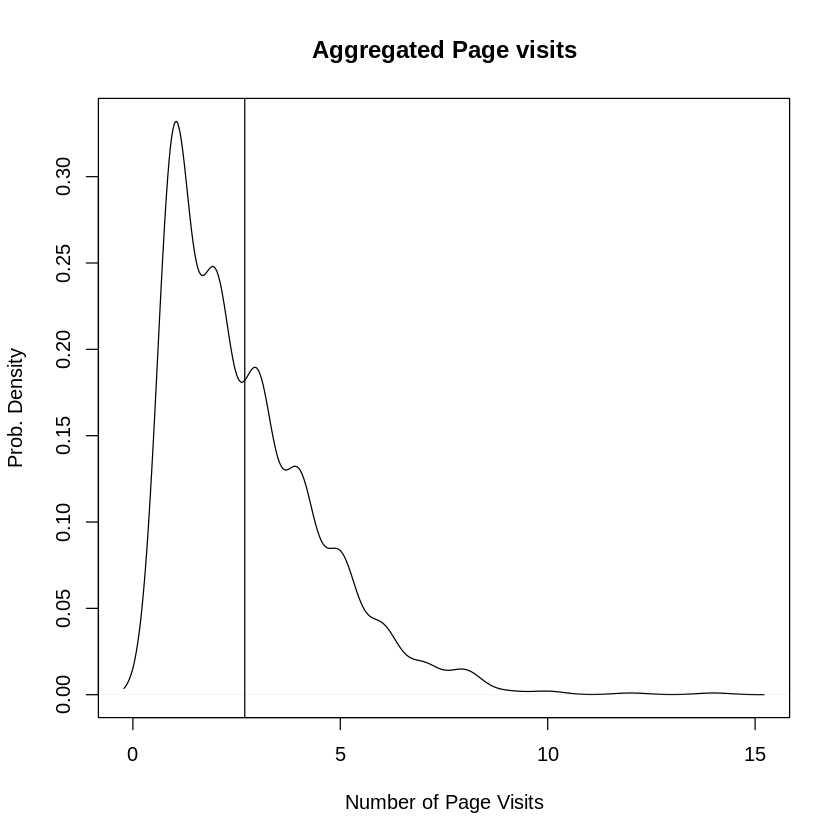

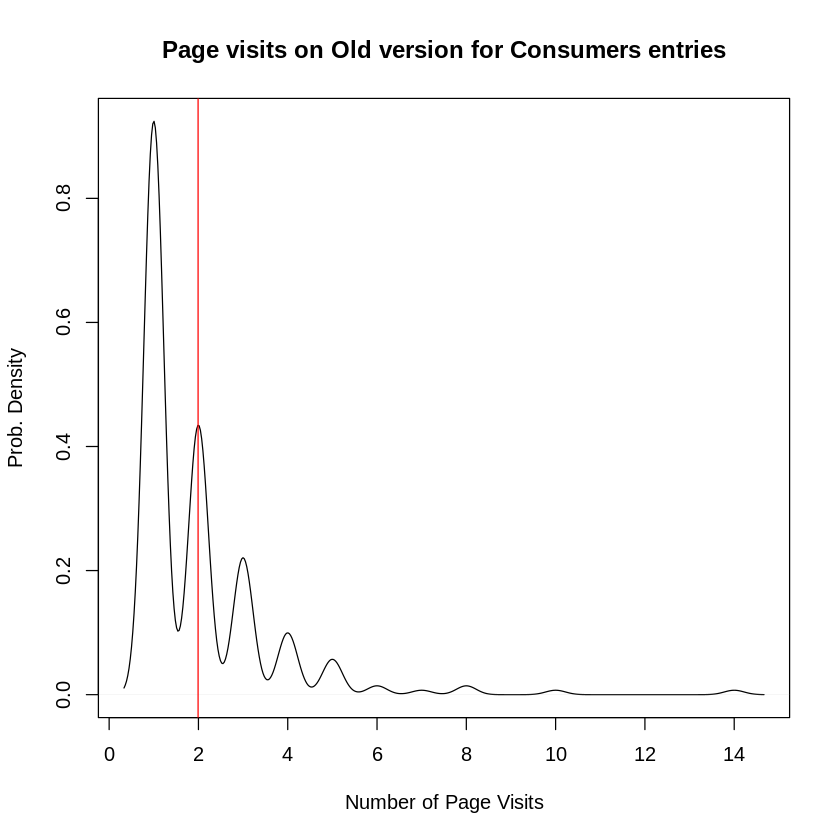

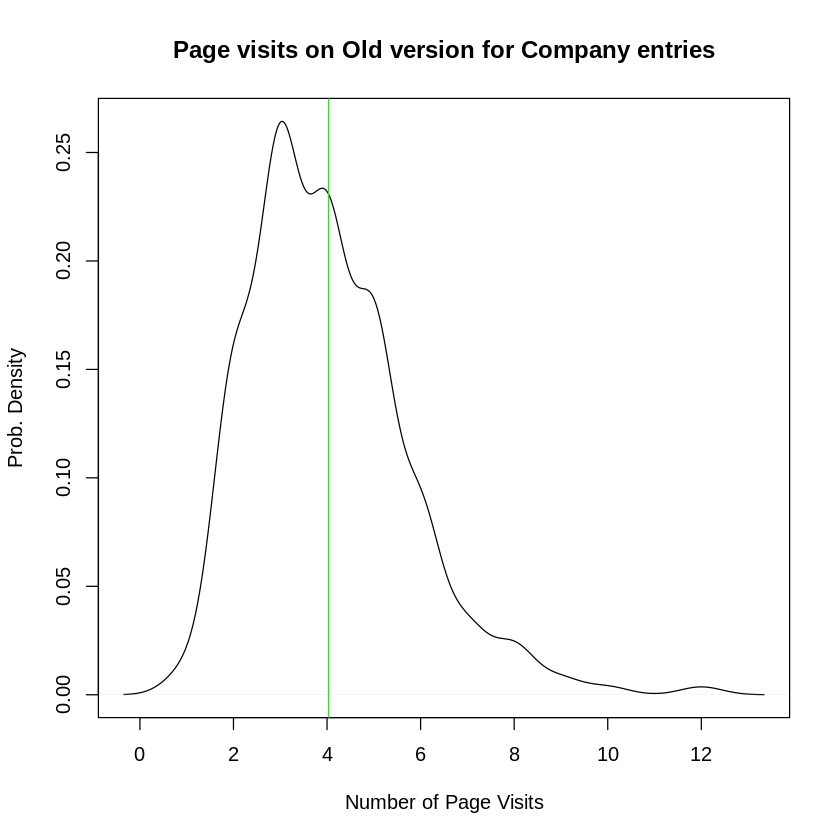

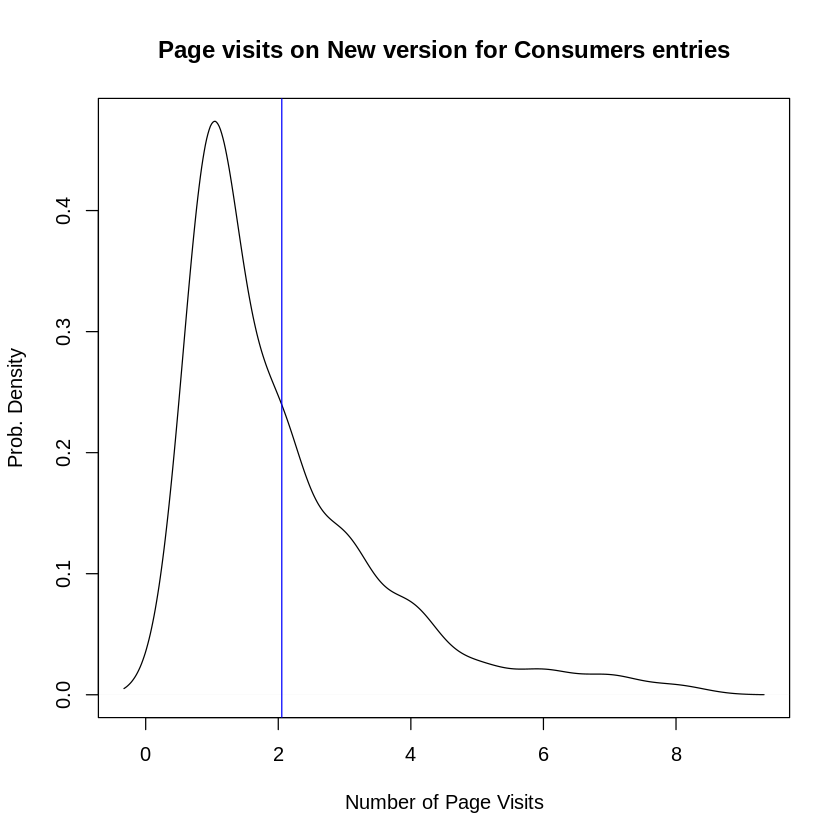

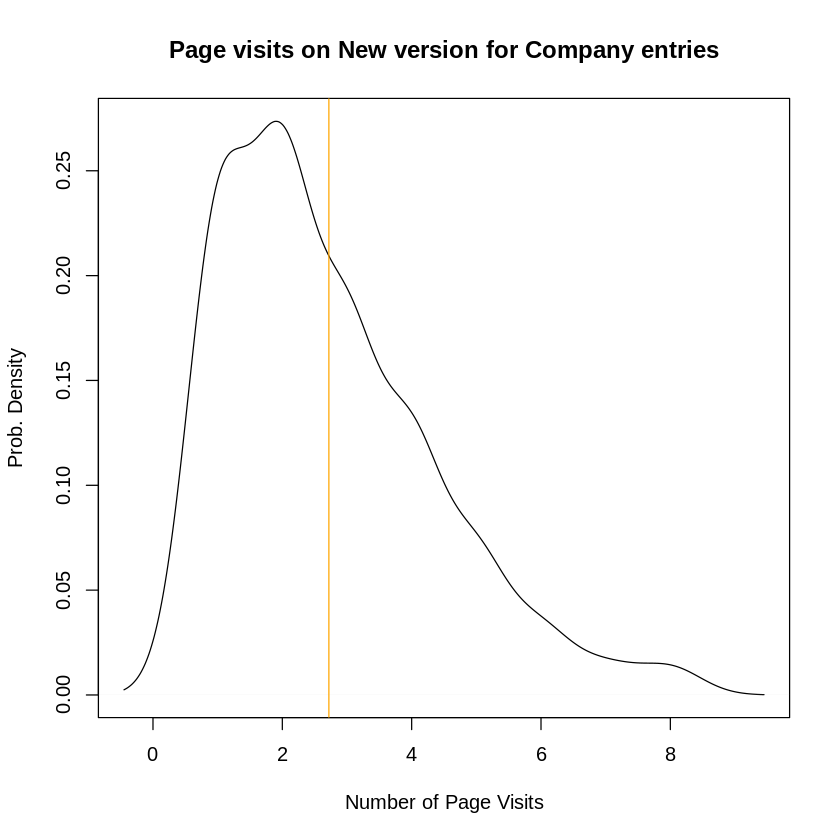

In [15]:
# Creating subsets of data for each combination of factors

subset00 <- subset(data, version == '0' & portal == '0')
subset01 <- subset(data, version == '0' & portal == '1')
subset10 <- subset(data, version == '1' & portal == '0')
subset11 <- subset(data, version == '1' & portal == '1')

# Generating density plots

d <- density(data$pages)
plot(d, xlab='Number of Page Visits', ylab='Prob. Density', main='Aggregated Page visits')
abline(v = mean(data$pages), col = "black")

d <- density(subset00$pages)
plot(d, xlab='Number of Page Visits', ylab='Prob. Density', main='Page visits on Old version for Consumers entries')
abline(v = mean(subset00$pages), col = "red")

d <- density(subset01$pages)
plot(d, xlab='Number of Page Visits', ylab='Prob. Density', main='Page visits on Old version for Company entries')
abline(v = mean(subset01$pages), col = "green")

d <- density(subset10$pages)
plot(d, xlab='Number of Page Visits', ylab='Prob. Density', main='Page visits on New version for Consumers entries')
abline(v = mean(subset10$pages), col = "blue")

d <- density(subset11$pages)
plot(d, xlab='Number of Page Visits', ylab='Prob. Density', main='Page visits on New version for Company entries')
abline(v = mean(subset11$pages), col = "orange")

# Levene test to check difference of variance
pander(leveneTest(data$pages, interaction(data$version, data$portal)))

The Density plots indicate that none of the Page visit densities resemble a Gaussian distribtuion, apart from the page visits for New version and Old version company entries. The rest have skewed distributions and the Page visits for Old version consumer entries resembles a mixture of densities.
The levene test also indicates that the Homogeniety of Variance assumption has been violated since the p-value is 0.053. 
Linear Model analysis assumes the fact that the target continuous variable has Gaussian-error distribution and thus uses appropriate log-likelihoods for the best MLE regression fit. Since the densities resemble a Poisson distribution, we use a General Linear Model with the family of distributions set to Poisson in order to conduct model fitting.

# Q4 

## a. Model Analysis

In [16]:
library(AICcmodavg)

# Model fitting for each factor and a combination of them

model0 <- glm(pages ~ 1, data=data, na.action=na.exclude, family=poisson())
model1 <- glm(pages ~ version, data=data, na.action=na.exclude, family=poisson())
model2 <- glm(pages ~ portal, data=data, na.action=na.exclude, family=poisson())
model3 <- glm(pages ~ version + portal, data=data, na.action=na.exclude, family=poisson())
model4 <- glm(pages ~ version + portal + version:portal, data=data, na.action=na.exclude, family=poisson())

# ANOVA results of the effect of adding the factors

pander(anova(model0, model1, test="Chisq"), caption='Version as main effect on Page visits')

pander(anova(model0, model2, test="Chisq"), caption='Portal as main effect on Page visits')

pander(anova(model3, model4, test="Chisq"), caption='Interaction effect vs 2 main effects')

pander(anova(model4, test="Chisq"), caption='Version, Portal and interaction effect on Page visits')

# AICc scores of the models

models <-list(model0, model1, model2, model3, model4)
model.names <-c("model0","model1","model2","model3","model4")
aictab(cand.set = models, modnames=model.names)



| Res.Df | RSS  | Df | Sum of Sq |   F   |  Pr(>F)   |
|:------:|:----:|:--:|:---------:|:-----:|:---------:|
|  998   | 3199 | NA |    NA     |  NA   |    NA     |
|  997   | 3107 | 1  |   92.2    | 29.59 | 6.731e-08 |

Table: Version as main effect on Page visits



| Res.Df | RSS  | Df | Sum of Sq |   F   |  Pr(>F)   |
|:------:|:----:|:--:|:---------:|:-----:|:---------:|
|  998   | 3199 | NA |    NA     |  NA   |    NA     |
|  997   | 2751 | 1  |   448.2   | 162.4 | 1.409e-34 |

Table: Portal as main effect on Page visits



| Res.Df | RSS  | Df | Sum of Sq |   F   |  Pr(>F)   |
|:------:|:----:|:--:|:---------:|:-----:|:---------:|
|  996   | 2652 | NA |    NA     |  NA   |    NA     |
|  995   | 2534 | 1  |   117.8   | 46.25 | 1.793e-11 |

Table: Interaction effect vs 2 main effects



|       &nbsp;       | Df  | Sum Sq | Mean Sq | F value |  Pr(>F)   |
|:------------------:|:---:|:------:|:-------:|:-------:|:---------:|
|    **version**     |  1  |  92.2  |  92.2   |  36.2

,Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Cum.Wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5,model4,5,3774.914,0.00000,1.000000e+00,1.000000e+00,-1882.427,1
4,model3,4,3818.284,43.36929,3.823648e-10,3.823648e-10,-1905.122,1
3,model2,3,3852.980,78.06582,1.117436e-17,1.117436e-17,-1923.478,1
2,model1,3,3974.555,199.64105,4.451406e-44,4.451406e-44,-1984.266,1
1,model0,2,4001.757,226.84276,5.517213e-50,5.517213e-50,-1998.873,1


The ANOVA results for the comparison of each model type indicate that the added values by including the factors individually, together and their interaction effect is statistically significant since all their p-values are <0.001. The AICc results show that model4 has the best goodness of fit since its corrected-AIC value is the least with the best log-likelihood score too. 

## b. Simple Effect Analysis 

In [20]:
data$simple <- interaction(data$version, data$portal)
contrast0 <-c(1,-1,0,0) #Only the 0-portal data
contrast1 <-c(0,0,1,-1) #Only the 1-portal data

SimpleEff <- cbind(contrast0,contrast1)
contrasts(data$simple) <- SimpleEff

simpleEffectModel <-glm(pages ~ simple , data = data, na.action = na.exclude, family=poisson())
pander(summary.lm(simpleEffectModel))



|       &nbsp;        | Estimate | Std. Error | t value |  Pr(>|t|)  |
|:-------------------:|:--------:|:----------:|:-------:|:----------:|
|   **(Intercept)**   |  2.699   |   0.0505   |  53.45  | 9.614e-295 |
| **simplecontrast0** | -0.03051 |  0.07166   | -0.4258 |   0.6703   |
| **simplecontrast1** |  0.6563  |  0.07117   |  9.222  | 1.695e-19  |
|     **simple**      |  1.354   |   0.101    |  13.4   |  8.88e-38  |



| Observations | Residual Std. Error | $R^2$  | Adjusted $R^2$ |
|:------------:|:-------------------:|:------:|:--------------:|
|     999      |        1.596        | 0.2079 |     0.2056     |

Table: Fitting linear model: pages ~ simple



After fitting a linear model on the data, it can be observed that the company portal entries (1) have a statistically significant difference and not the consumer portal entries (0). This observation also agrees with the first plot indicating the variation in page visits for the 2 factors. The 1-portal page visits have a larger difference than the 0-portal page visits for the 0 and 1 - versions.

## c. Report 

A general linear model with poisson distribution was fit on the number of page visits by users, taking website version and web portal entires as independent variables, and including a two-way interaction between these variables.
The analysis found a significant main effect (Chisq (1, 997) = 1033, p. < 0.01) for the version factor and (Chisq (1, 996) = 862, p. < 0.01) for portal factor. The analysis also found a significant two-way interaction effect (Chisq (1, 995) = 834, p. < 0.01) between these two variables. A Simple Effect analysis further examined the two-way interaction. It revealed a significant (z = 7.975, p. < 0.01) difference for the web portal entries by companies (1), but no significant effect (t = -0.4779, p. = 0.6328) was found for the web portal entries by consumers (0).

# Q5 

## a. Model Fitting 

A Poisson distribution model is fitted to each of the models. Model m0 is the base model with only an intercept. Model m1 is an extension of model m0 where the version in introduced as a predictor. Model m2 is again an extension of model m0 with portal as a predictor. In model m3, both predictors are added as main effects, and model m4 extends model m3 by adding a two-way interaction effect between version and portal in the model. 

The most complete model is the one which uses both the factors (Version and Portal) to determine the lambda (mean and variance) of the Poisson distribution to model the dependent variable of Page Visits. The prior for the first variable 'a' is chosen to be a normal distribution with the mean as the mean of the page visits from the data and the uncertainty in this estimate is reflected by the standard deviation of the mean page visits as 1. The priors for the coefficients of Version and Portal are chosen to be normal distributions of mean 2 and deviation 1, mean 0 and deviation 1 since these will be anyway adjusted by the counts of the factors. The choice of these priors are based on intuitve understanding of the page visits based on the 2 factors of version and portal type that influence the number of page visits.

$$ pages \sim Poisson(\lambda) $$

$$ \lambda = a + b*versionN + c*portalN + d*versionN*portalN$$

$$ a \sim Norm(2, 1) $$
$$ b \sim Norm(2, 1) $$
$$ c \sim Norm(0, 1) $$
$$ d \sim Norm(0, 1) $$

In [16]:
library(rethinking)

#Modifying dtypes of factor columns

datasub <- subset(data, select = c(pages, version, portal))
datasub$versionN <- as.numeric(datasub$version)
datasub$portalN <- as.numeric(datasub$portal)

#Fitting each variant of the model

m0 <-map2stan(    
  alist(
    pages ~ dpois(lambda),
    log(lambda) <- a ,
    a ~ dnorm(2, 1)
  ), data = datasub, iter = 10000, chains = 4, cores = 4
)

m1 <-map2stan(    
  alist(
    pages ~ dpois(lambda),
    log(lambda) <- a + b*versionN ,
    a ~ dnorm(2, 1),
    b ~ dnorm(2, 1)
  ), data = datasub, iter = 10000, chains = 4, cores = 4
)

m2 <-map2stan(    
  alist(
    pages ~ dpois(lambda),
    log(lambda) <- a + b*portalN ,
    a ~ dnorm(2, 1),
    b ~ dnorm(0, 1)
  ), data = datasub, iter = 10000, chains = 4, cores = 4
)

m3 <-map2stan(    
  alist(
    pages ~ dpois(lambda),
    log(lambda) <- a + b*versionN + c*portalN ,
    a ~ dnorm(2, 1),
    b ~ dnorm(2, 1),
    c ~ dnorm(0, 1)
  ), data = datasub, iter = 10000, chains = 4, cores = 4
)

m4 <-map2stan(    
  alist(
    pages ~ dpois(lambda),
    log(lambda) <- a + b*versionN + c*portalN + d*versionN*portalN ,
    a ~ dnorm(2, 1),
    b ~ dnorm(2, 1),
    c ~ dnorm(0, 1),
    d ~ dnorm(0, 1),
  ), data = datasub, iter = 10000, chains = 4, cores = 4
)


Warning message:
“package ‘rethinking’ was built under R version 4.0.3”Loading required package: rstan
Warning message:
“package ‘rstan’ was built under R version 4.0.3”Loading required package: StanHeaders
Warning message:
“package ‘StanHeaders’ was built under R version 4.0.3”Error: package or namespace load failed for ‘rstan’ in dyn.load(file, DLLpath = DLLpath, ...):
 unable to load shared object '/home/anuj/anaconda3/envs/r/lib/R/library/rstan/libs/rstan.so':
  /home/anuj/anaconda3/envs/r/lib/R/library/rstan/libs/rstan.so: undefined symbol: EXTPTR_PTR


ERROR: Error: package ‘rstan’ could not be loaded


## b. Compare 

In [17]:
compare(m0,m1,m2,m3,m4)
precis(m4, prob= .95)

,WAIC,SE,dWAIC,dSE,pWAIC,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m4,3777.675,86.59279,0.00000,NA,7.531376,1.000000e+00
m3,3820.654,81.82864,42.97967,13.43159,6.307824,4.646035e-10
m2,3855.133,82.00036,77.45840,18.47039,5.127272,1.513985e-17
m1,3975.880,69.20848,198.20557,32.78639,4.314846,9.124468e-44
m0,4003.254,69.91779,225.57964,34.39160,3.438160,1.037536e-49


The compare() function indicates the best goodness of fit has been observed for the model m4 with the least WAIC value. For further investigation of the 95% credibility intervals, the precis() function indicates that the mean value of the coefficient of version is approximately 0, unlike for the coefficients of all the other variables (c, d for portal and two-way interaction respectively). 

In [19]:
# datasub0 <- subset(datasub, portal == "0")
# bayes.t.test(pages~version, data = datasub0)

# datasub1 <- subset(datasub, portal == "1")
# bayes.t.test(pages~version, data = datasub1)

ERROR: Error in bayes.t.test(pages ~ version, data = datasub0): could not find function "bayes.t.test"
